In [17]:
#Imports
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import copy
import pfr
import time
from sklearn.grid_search import GridSearchCV

In [2]:
# reupload all data to have as one dataset again
completedf1 = pd.concat([pd.read_csv('0204plays.csv'),pd.read_csv('0507plays.csv'),pd.read_csv('0810plays.csv'),pd.read_csv('1114plays.csv')])

#(remove 2002, because it has served it's purpose of creating 2003 priors)
completedf = completedf1[completedf1['year']>2002].reset_index(drop=True)

# define number of plays in df, which is now our finalized dataset with all variables
plays = len(completedf)

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (63,102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
print completedf.shape
completedf.head(2)

lcols = ["distToGoal","inDown3","inDown2","inDown1","inQuarter4","inQuarter3","inQuarter2","inQuarter1","secsElapsedInHalf","margin","yds_to_go","addscore","tm_TO_left","opp_TO_left","inFGRange", "inRedZone", "tm_winprob","inLast3minHalf", "tm_prev_yr_pass","tm_in_season_pass","tm_in_game_pass","StartofDrive","prevWasPass"]

(397349, 139)


In [4]:
def masking(df,itrain,itest):    
    mask=np.ones(df.shape[0], dtype='int')
    mask[itrain]=1
    mask[itest]=0
    mask = (mask==1)
    return mask

In [5]:
def runsvm(Xmatrix, Yresp, mask, Cs):
    Xmatrix_train=Xmatrix[mask]
    Xmatrix_test=Xmatrix[~mask]
    Yresp_train=Yresp[mask]
    Yresp_test=Yresp[~mask]
    
    from sklearn.svm import LinearSVC
    clfsvm_lin=LinearSVC(loss="hinge")
    
    from sklearn.grid_search import GridSearchCV
    gs=GridSearchCV(clfsvm_lin, param_grid={'C':Cs}, cv=5)
    gs.fit(Xmatrix_train, Yresp_train)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    
    best = gs.best_estimator_
    print best.fit(Xmatrix_train, Yresp_train)
    print best.score(Xmatrix_test, Yresp_test)
    
    return best
    

def runsvc(Xmatrix, Yresp, mask, Cs):
    Xmatrix_train=Xmatrix[mask]
    Xmatrix_test=Xmatrix[~mask]
    Yresp_train=Yresp[mask]
    Yresp_test=Yresp[~mask]
    
    from sklearn.svm import SVC
    clfsvm_orig = SVC()
    
    from sklearn.grid_search import GridSearchCV
    gs_orig = GridSearchCV(clfsvm_orig, param_grid={'C':Cs}, cv=5)
    gs_orig.fit(Xmatrix_train, Yresp_train)
    print "BEST", gs_orig.best_params_, gs_orig.best_score_, gs_orig.grid_scores_
    
    best_orig = gs_orig.best_estimator_
    print best_orig.fit(Xmatrix_train, Yresp_train)
    print best_orig.score(Xmatrix_test, Yresp_test)
    
    return best_orig

In [6]:
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [7]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.6f" % (training_accuracy)
    print "Accuracy on test data:     %0.6f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [8]:
def randforest(df,lcols,mask):    
    from sklearn.ensemble import RandomForestClassifier
    clfForest = RandomForestClassifier()
    parameters = {"n_estimators": range(1,40)}
    # could add njobs to the mix to run them in parallel
    clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfForest

def gradboost(df,lcols,mask):
    from sklearn.ensemble import GradientBoostingClassifier
    clfGB = GradientBoostingClassifier()
    parameters = {"n_estimators": range(1, 20)}
    clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfGB

def adaboost(clfForest,df,lcols,mask):
    from sklearn.ensemble import AdaBoostClassifier
    clfAda = AdaBoostClassifier(base_estimator=clfForest)
    parameters = {"n_estimators": range(1, 20)}
    clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfAda

In [9]:
def plot_features(clfForest,lcols):
    importance_list = clfForest.feature_importances_
    importance_list, name_list = zip(*sorted(zip(importance_list, lcols)))
    plt.barh(range(len(name_list)),importance_list,align='center')
    plt.yticks(range(len(name_list)),name_list)
    plt.xlabel('Relative Importance in the Random Forest')
    plt.ylabel('Features')
    plt.title('Relative Importance of Each Feature')
    plt.show()
    

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    
    print type(X_train[:, 0].min()), type(plot_step)
    

def plot_rf(clfForest,clflog,lcols,df):
    xt = [lcols[e] for e in clfForest.feature_importances_.argsort()[::-1][0:2]]
    X_imp = df[xt].values
    Y = df.RESP.values

    classifiers = [clfForest, clflog]

    titleClassifer = ['Random Forest Classifier', "Logistic Regression Classifier"]
    for c in range(len(classifiers)):
        plt.title(titleClassifer[c])
        plt.xlabel(xt[0])
        plt.ylabel(xt[1])
        plot_decision_surface(classifiers[c], X_imp, Y)

In [10]:
def model(completedf,year):
    # use the dataframe for the input year
    df = completedf[completedf['year']==year]
    
    #Split into train and test, create mask
    from sklearn.cross_validation import train_test_split
    itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)
    mask = masking(df,itrain,itest)
    
    # initialize variables for svm/svc
    Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # try fewer if doesnt finish up
    Xmatrix=df[lcols].values
    Yresp=df['RESP'].values
    
    # run svm  
    best = runsvm(Xmatrix, Yresp, mask, Cs)
    
    # run svc    
    best_orig = runsvc(Xmatrix, Yresp, mask, Cs)
    
    # run logistic models
    from sklearn.linear_model import LogisticRegression
    clflog,_,_,_,_ = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)
    clflog2,_,_,_,_ = do_classify(LogisticRegression(penalty="l2"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)
    
    #Random forest classifier and make random forest plots
    clfForest = randforest(df,lcols,mask)
    plot_features(clfForest,lcols)
    plot_rf(clfForest,clflog,lcols,df)
    
    # ADA Boost Classifier
    clfAda = adaboost(clfForest,df,lcols,mask)
    
    # Gradient Boost CLassifier
    clfGB = gradboost(df,lcols,mask)

    return best, best_orig, clflog, clflog2, clfForest, clfAda, clfGB

In [11]:
#clfsvm, clfsvc, clflog, clflog2, clfForest, clfAda, clfGB = model(completedf, 2014)

In [12]:
year = 2007 # whatever year you want to test
df = completedf[completedf['year']==year]

In [13]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)
mask = masking(df,itrain,itest)
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # try fewer if doesnt finish up
Xmatrix=df[lcols].values
Yresp=df['RESP'].values

In [14]:
# run svm
best = runsvm(Xmatrix, Yresp, mask, Cs)

BEST {'C': 10.0} 0.589909102885 [mean: 0.56984, std: 0.05381, params: {'C': 0.001}, mean: 0.54099, std: 0.05416, params: {'C': 0.01}, mean: 0.53238, std: 0.06667, params: {'C': 0.1}, mean: 0.55509, std: 0.05739, params: {'C': 1.0}, mean: 0.58991, std: 0.02451, params: {'C': 10.0}, mean: 0.54806, std: 0.03767, params: {'C': 100.0}]
LinearSVC(C=10.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
0.600102459016


In [15]:
# run svc    
best_orig = runsvc(Xmatrix, Yresp, mask, Cs)

BEST {'C': 1.0} 0.579106837044 [mean: 0.57871, std: 0.00001, params: {'C': 0.001}, mean: 0.57871, std: 0.00001, params: {'C': 0.01}, mean: 0.57871, std: 0.00001, params: {'C': 0.1}, mean: 0.57911, std: 0.00162, params: {'C': 1.0}, mean: 0.57739, std: 0.00218, params: {'C': 10.0}, mean: 0.57766, std: 0.00239, params: {'C': 100.0}]
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.563114754098


In [18]:
# run logistic model
from sklearn.linear_model import LogisticRegression
clflog,_,_,_,_ = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)

using mask
BEST {'C': 100} 0.65498616783 [mean: 0.59127, std: 0.01428, params: {'C': 0.001}, mean: 0.64682, std: 0.01251, params: {'C': 0.01}, mean: 0.65244, std: 0.01464, params: {'C': 0.1}, mean: 0.65481, std: 0.01494, params: {'C': 1}, mean: 0.65490, std: 0.01511, params: {'C': 10}, mean: 0.65499, std: 0.01466, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.657313
Accuracy on test data:     0.655430
[[2236 1964]
 [1399 4161]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [19]:
# run logistic model 2
clflog2,_,_,_,_ = do_classify(LogisticRegression(penalty="l2"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)

using mask
BEST {'C': 100} 0.655644842577 [mean: 0.64001, std: 0.01332, params: {'C': 0.001}, mean: 0.65077, std: 0.01357, params: {'C': 0.01}, mean: 0.65455, std: 0.01472, params: {'C': 0.1}, mean: 0.65516, std: 0.01425, params: {'C': 1}, mean: 0.65477, std: 0.01438, params: {'C': 10}, mean: 0.65564, std: 0.01429, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.657226
Accuracy on test data:     0.654713
[[2239 1961]
 [1409 4151]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [20]:
#Random forest classifier
clfForest = randforest(df,lcols,mask)

using mask
BEST {'n_estimators': 29} 0.718789356512 [mean: 0.65806, std: 0.00942, params: {'n_estimators': 1}, mean: 0.56581, std: 0.01668, params: {'n_estimators': 2}, mean: 0.67271, std: 0.01265, params: {'n_estimators': 3}, mean: 0.63055, std: 0.01528, params: {'n_estimators': 4}, mean: 0.69208, std: 0.01460, params: {'n_estimators': 5}, mean: 0.65381, std: 0.02286, params: {'n_estimators': 6}, mean: 0.69646, std: 0.01404, params: {'n_estimators': 7}, mean: 0.67820, std: 0.01430, params: {'n_estimators': 8}, mean: 0.69861, std: 0.01385, params: {'n_estimators': 9}, mean: 0.68174, std: 0.01469, params: {'n_estimators': 10}, mean: 0.69870, std: 0.01493, params: {'n_estimators': 11}, mean: 0.69068, std: 0.02162, params: {'n_estimators': 12}, mean: 0.70787, std: 0.01494, params: {'n_estimators': 13}, mean: 0.69745, std: 0.01584, params: {'n_estimators': 14}, mean: 0.70889, std: 0.01747, params: {'n_estimators': 15}, mean: 0.69651, std: 0.01860, params: {'n_estimators': 16}, mean: 0.7113

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


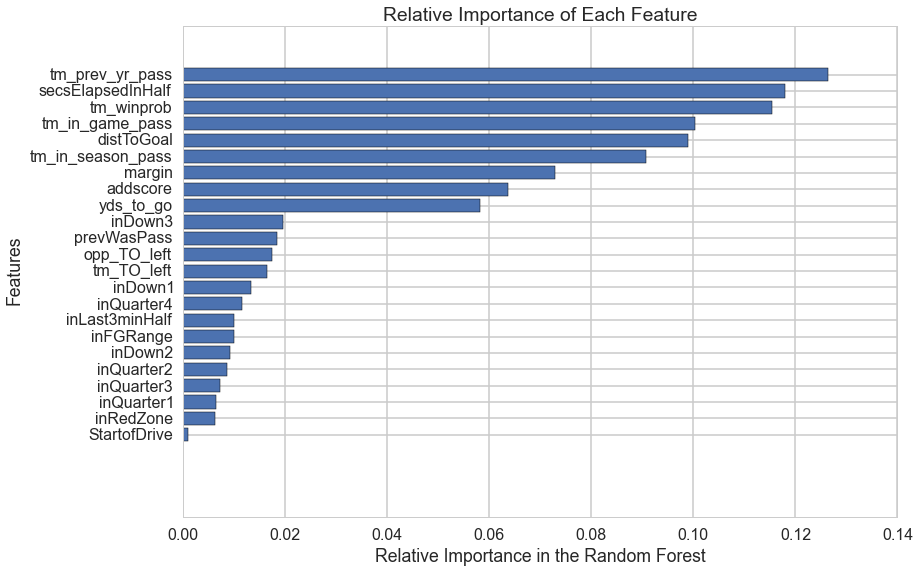

In [21]:
# make random forest plots
plot_features(clfForest,lcols)

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


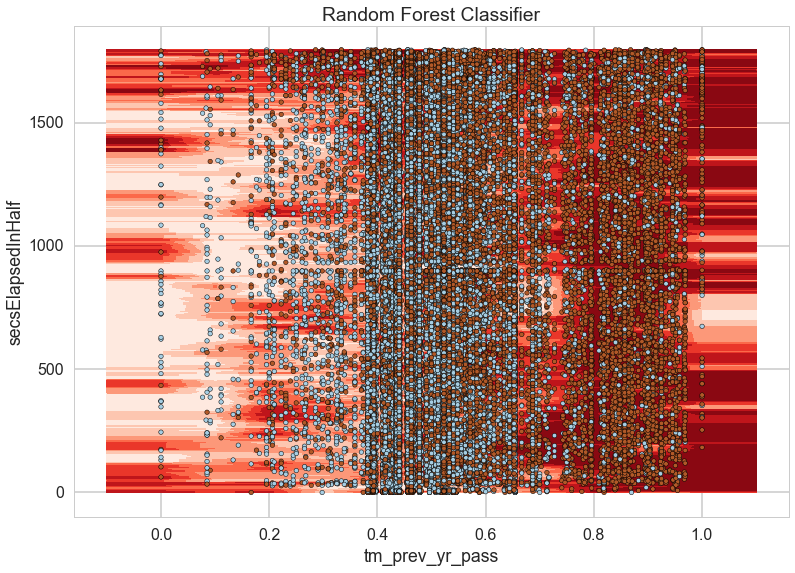

<type 'numpy.float64'> <type 'float'>


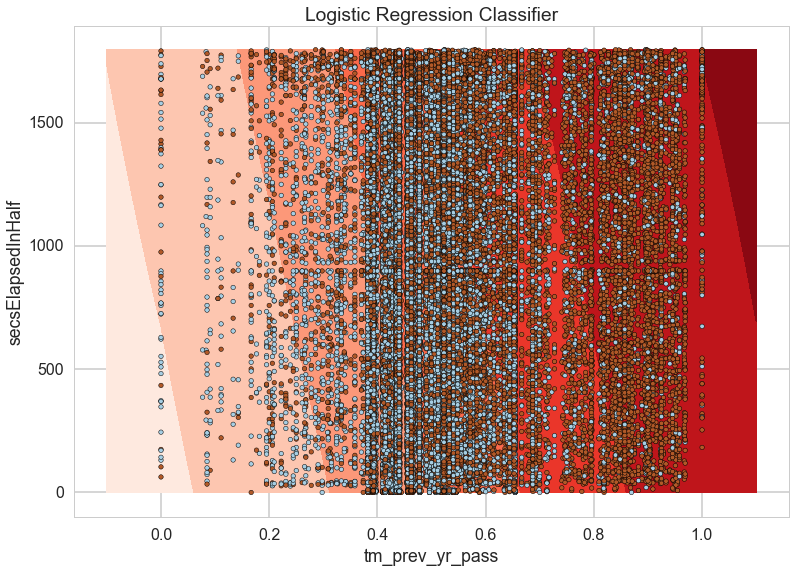

<type 'numpy.float64'> <type 'float'>


In [ ]:
# make random forest plots
plot_rf(clfForest,clflog,lcols,df)

In [ ]:
# ADA Boost Classifier
clfAda = adaboost(clfForest,df,lcols,mask)

In [ ]:
# Gradient Boost CLassifier
clfGB = gradboost(df,lcols,mask)